# Transit-Supportive Density and Equity Analysis – Washington, DC

This notebook explores how different definitions of **transit-supportive density (TSD)** influence which Washington, DC Metro station areas are classified as "transit-ready," and whether those classifications have equity implications. 

Using spatial analysis in Python, we:
- Calculate four common TSD metrics: **people per acre**, **housing units per acre**, **jobs per acre** (proxied via commuter counts), and a **combined people + jobs metric**
- Classify each station area as meeting or not meeting TSD thresholds based on planning literature
- Compare which stations are flagged under each metric
- Evaluate demographic differences—**percent Black population, poverty rate, and renter share**—between TSD and non-TSD areas using **Mann-Whitney U tests**
- Assess agreement between metrics using **McNemar’s test**
- Generate charts and maps to visualize spatial patterns and statistical findings

This functional analysis was developed in response to a fictional request from the **Washington Metropolitan Area Transit Authority (WMATA)** to examine whether the technical definitions used in transit planning could unintentionally exclude communities of color or low-income renters from TOD investment.


In [26]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 13.9 MB/s eta 0:00:00a 0:00:01


In [2]:
# File paths
station_fp = "Metro_Stations_in_DC.geojson"
tracts_fp = "tl_2023_11_tract/tl_2023_11_tract.shp"
acs_fp = "acs_population_data.csv"
ctpp_fp = "ctpp_commuters.csv"

# Load files
stations = gpd.read_file(station_fp)
tracts = gpd.read_file(tracts_fp)
acs = pd.read_csv(acs_fp)
ctpp = pd.read_csv(ctpp_fp)

In [3]:
# Clean ACS and CTPP columns BEFORE merging
for col in ["population", "housing_units", "pct_black", "pct_poverty", "pct_renters"]:
    acs[col] = acs[col].astype(str).str.replace(",", "").str.strip()
    acs[col] = pd.to_numeric(acs[col], errors="coerce")

ctpp["total_commuters"] = ctpp["total_commuters"].astype(str).str.replace(",", "").str.strip()
ctpp["total_commuters"] = pd.to_numeric(ctpp["total_commuters"], errors="coerce")

In [4]:
# Standardize GEOIDs
for df in [tracts, acs, ctpp]:
    df["GEOID"] = df["GEOID"].astype(str).str.zfill(11)

# Merge ACS and CTPP into tracts
tracts = tracts.merge(acs, on="GEOID")
tracts = tracts.merge(ctpp, on="GEOID")

# Drop duplicates if needed
tracts = tracts.loc[:, ~tracts.columns.duplicated()]

# Convert all important columns to numeric
for col in ["population", "housing_units", "pct_black", "pct_poverty", "pct_renters", "total_commuters"]:
    tracts[col] = pd.to_numeric(tracts[col], errors="coerce")

In [5]:
print(tracts[["population", "housing_units", "total_commuters"]].describe())

        population  housing_units  total_commuters
count   205.000000     205.000000       205.000000
mean   3278.351220    1737.053659      2986.243902
std    1072.809082     597.942594      7176.705290
min    1181.000000       0.000000        10.000000
25%    2508.000000    1345.000000       615.000000
50%    3224.000000    1685.000000      1145.000000
75%    3964.000000    2188.000000      2145.000000
max    7269.000000    3976.000000     68135.000000


In [6]:
# Project to EPSG:26985 (Maryland State Plane)
tracts = tracts.to_crs(epsg=26985)
stations = stations.to_crs(epsg=26985)

# Calculate tract area in acres
tracts["tract_area_acres"] = tracts.geometry.area / 4046.86

In [7]:
# Create 0.5 mile buffer (804.672 meters)
stations["geometry"] = stations.geometry.buffer(804.672)

# Keep only necessary columns before join to avoid conflicts
tracts = tracts[[
    "GEOID", "population", "housing_units", "pct_black", "pct_poverty", "pct_renters",
    "total_commuters", "tract_area_acres", "geometry"
]]

# Spatial join: which tracts intersect each station buffer
join = gpd.sjoin(tracts, stations, predicate="intersects")

# Drop any duplicated columns
join = join.loc[:, ~join.columns.duplicated()]

In [8]:
# Compute population-weighted demographic values
join["pct_black_weighted"] = join["pct_black"] * join["population"]
join["pct_poverty_weighted"] = join["pct_poverty"] * join["population"]
join["pct_renters_weighted"] = join["pct_renters"] * join["population"]

In [9]:
# Group by station (index_right is from spatial join)
station_summary = join.groupby("index_right").agg({
    "population": "sum",
    "housing_units": "sum",
    "total_commuters": "sum",
    "tract_area_acres": "sum",
    "pct_black_weighted": "sum",
    "pct_poverty_weighted": "sum",
    "pct_renters_weighted": "sum"
}).reset_index()

# Calculate weighted demographic percentages
station_summary["pct_black"] = station_summary["pct_black_weighted"] / station_summary["population"]
station_summary["pct_poverty"] = station_summary["pct_poverty_weighted"] / station_summary["population"]
station_summary["pct_renters"] = station_summary["pct_renters_weighted"] / station_summary["population"]

In [11]:
# Calculate densities per acre
station_summary["people_per_acre"] = station_summary["population"] / station_summary["tract_area_acres"]
station_summary["housing_units_per_acre"] = station_summary["housing_units"] / station_summary["tract_area_acres"]
station_summary["commuters_per_acre"] = station_summary["total_commuters"] / station_summary["tract_area_acres"]
station_summary["people_commuters_per_acre"] = (
    (station_summary["population"] + station_summary["total_commuters"]) / station_summary["tract_area_acres"]
)

In [12]:
#Apply thresholds for TSD
station_summary["tsd_people"] = station_summary["people_per_acre"] >= 15
station_summary["tsd_housing"] = station_summary["housing_units_per_acre"] >= 8
station_summary["tsd_jobs"] = station_summary["commuters_per_acre"] >= 25
station_summary["tsd_combined"] = station_summary["people_commuters_per_acre"] >= 45

# Count stations that meet each threshold
print("Stations meeting TSD thresholds:")
print(station_summary[["tsd_people", "tsd_housing", "tsd_jobs", "tsd_combined"]].sum())

Stations meeting TSD thresholds:
tsd_people      29
tsd_housing     32
tsd_jobs        19
tsd_combined    23
dtype: int64


In [13]:
# Compare average % Black for stations that did/didn't meet each threshold
for metric in ["tsd_people", "tsd_housing", "tsd_jobs", "tsd_combined"]:
    print(f"\nEquity check for {metric}:")
    print(station_summary.groupby(metric)["pct_black"].mean())


Equity check for tsd_people:
tsd_people
False    0.394101
True     0.293867
Name: pct_black, dtype: float64

Equity check for tsd_housing:
tsd_housing
False    0.466027
True     0.285282
Name: pct_black, dtype: float64

Equity check for tsd_jobs:
tsd_jobs
False    0.424371
True     0.207655
Name: pct_black, dtype: float64

Equity check for tsd_combined:
tsd_combined
False    0.468989
True     0.212367
Name: pct_black, dtype: float64


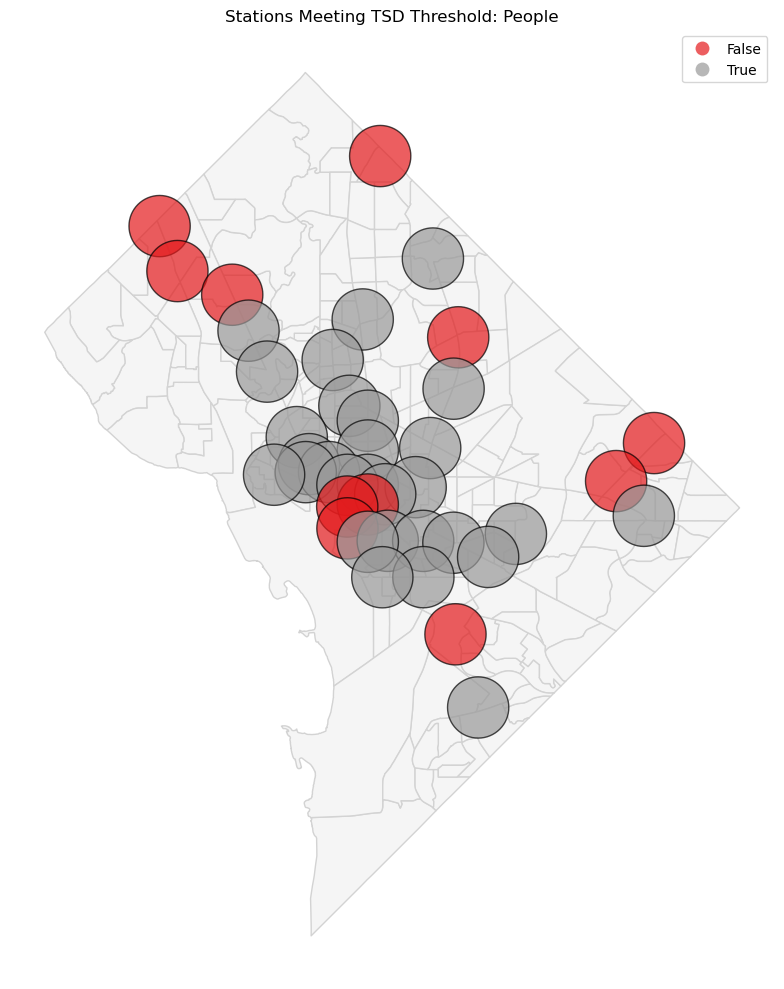

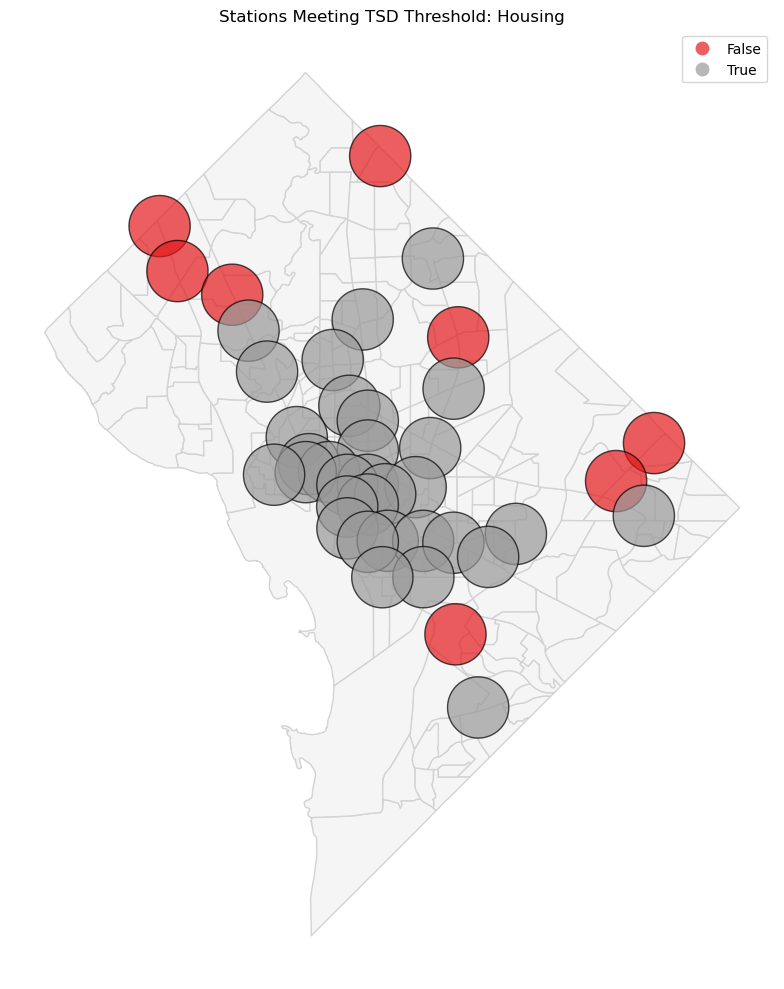

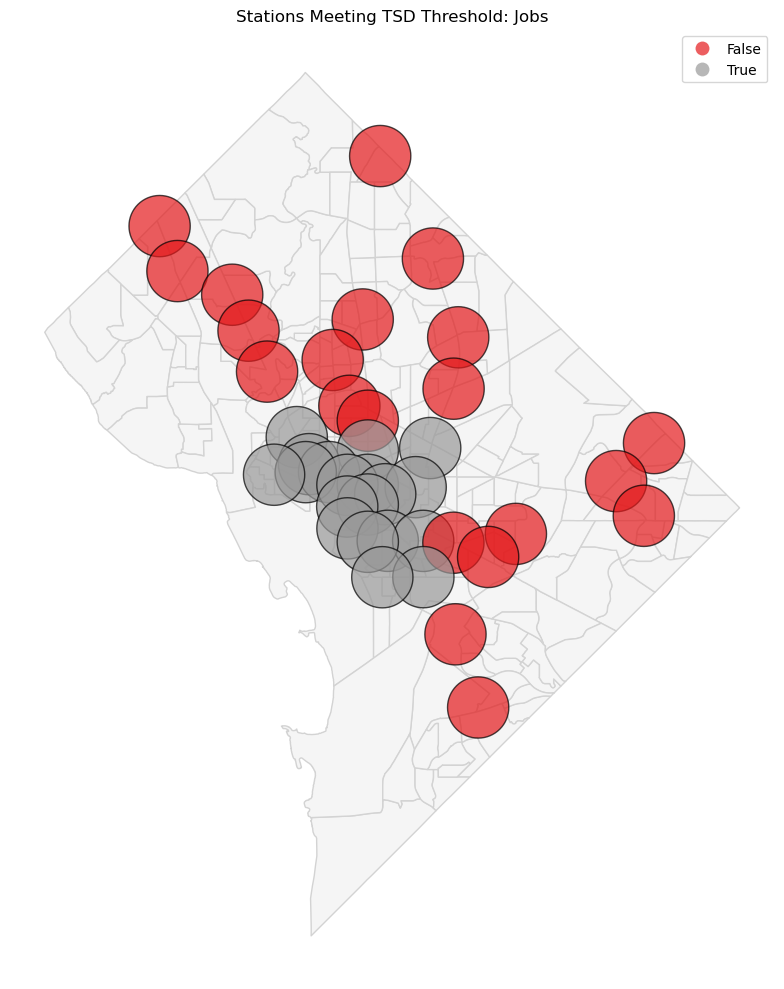

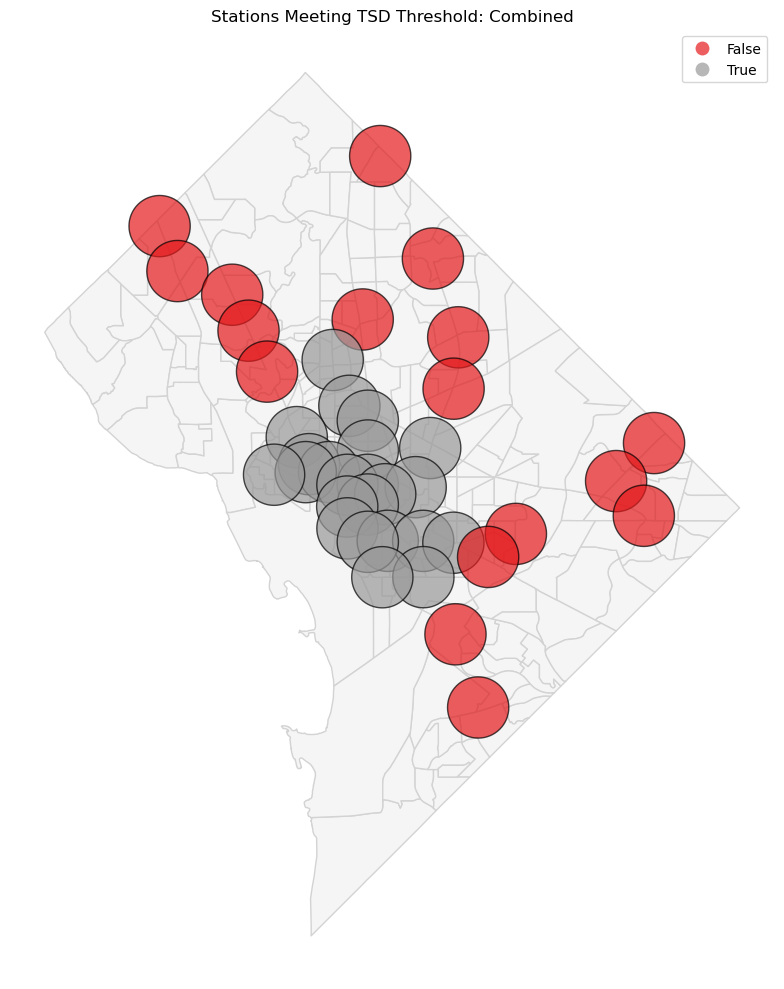

In [39]:
# Load station buffers (ensure they're the same CRS as station_summary)
station_buffers = gpd.read_file("Metro_Stations_in_DC.geojson").to_crs(epsg=26985)
station_buffers["geometry"] = station_buffers.geometry.buffer(804.672)
station_buffers = station_buffers.reset_index().rename(columns={"index": "station_index"})

# Merge with station_summary to get TSD flags
tsd_flags = station_summary[["index_right", "tsd_people", "tsd_housing", "tsd_jobs", "tsd_combined"]].copy()
tsd_flags = tsd_flags.rename(columns={"index_right": "station_index"})
station_buffers = station_buffers.merge(tsd_flags, on="station_index", how="left")

# Plot each TSD metric
for metric in ["tsd_people", "tsd_housing", "tsd_jobs", "tsd_combined"]:
    fig, ax = plt.subplots(figsize=(10, 10))
    base = gpd.read_file("tl_2023_11_tract/tl_2023_11_tract.shp").to_crs(epsg=26985)
    base.plot(ax=ax, color="whitesmoke", edgecolor="lightgray")
    station_buffers.plot(ax=ax, column=metric, legend=True, cmap="Set1", edgecolor="black", alpha=0.7)
    plt.title(f"Stations Meeting TSD Threshold: {metric.replace('tsd_', '').title()}")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig("tsd_combined.png", dpi=300, bbox_inches="tight")
    plt.show()

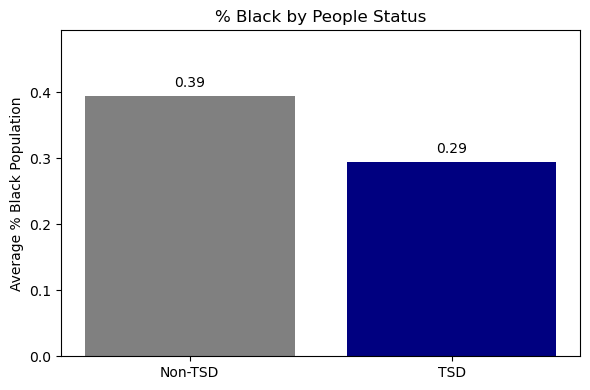

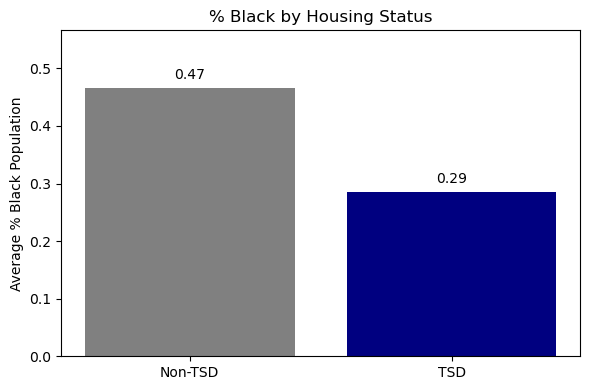

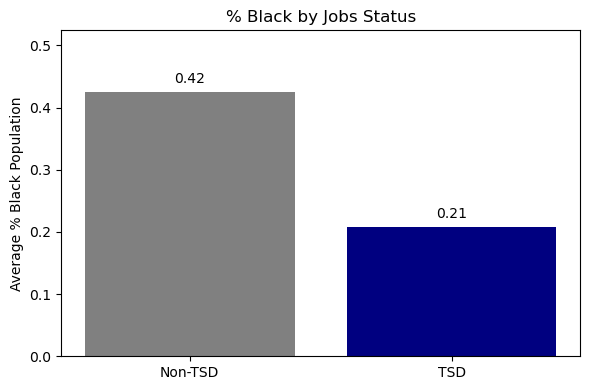

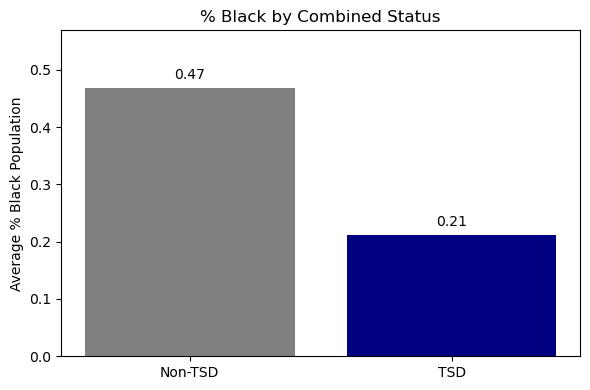

In [38]:
metrics = ["tsd_people", "tsd_housing", "tsd_jobs", "tsd_combined"]

for metric in metrics:
    group_means = station_summary.groupby(metric)["pct_black"].mean()
    labels = ["Non-TSD", "TSD"]
    values = [group_means.get(False, 0), group_means.get(True, 0)]

    plt.figure(figsize=(6, 4))
    bars = plt.bar(labels, values, color=["gray", "navy"])
    plt.title(f"% Black by {metric.replace('tsd_', '').title()} Status")
    plt.ylabel("Average % Black Population")
    plt.ylim(0, max(values) + 0.1)

    # Add value labels
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig("blackbymetric.png", dpi=300, bbox_inches="tight")
    plt.show()

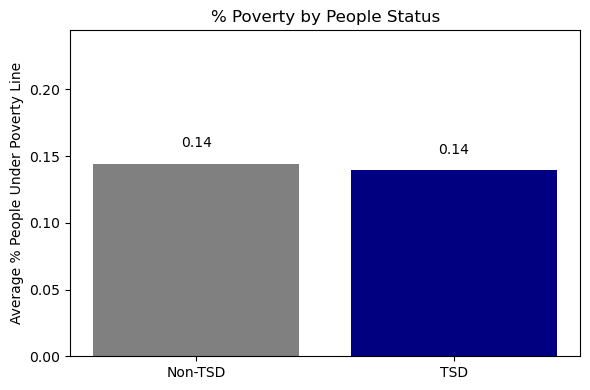

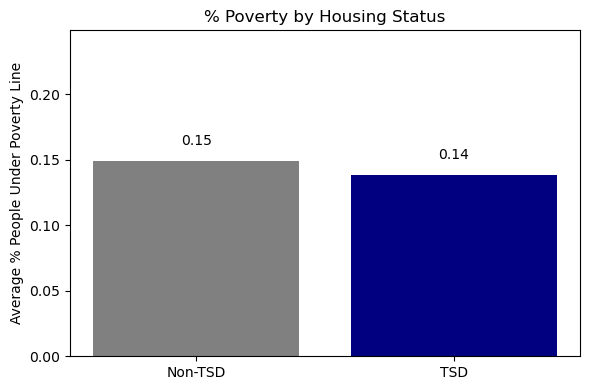

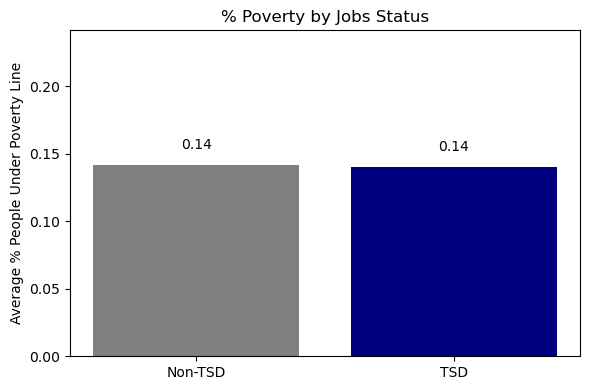

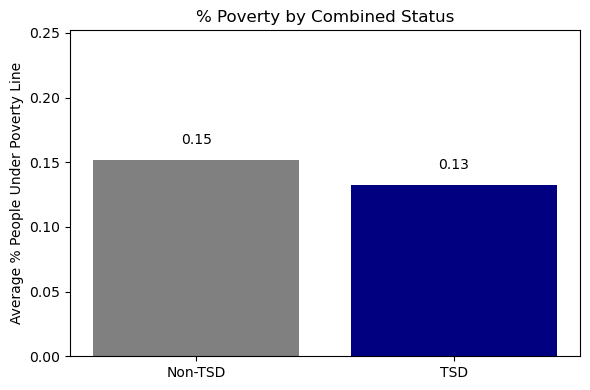

In [37]:
metrics = ["tsd_people", "tsd_housing", "tsd_jobs", "tsd_combined"]

for metric in metrics:
    group_means = station_summary.groupby(metric)["pct_poverty"].mean()
    labels = ["Non-TSD", "TSD"]
    values = [group_means.get(False, 0), group_means.get(True, 0)]

    plt.figure(figsize=(6, 4))
    bars = plt.bar(labels, values, color=["gray", "navy"])
    plt.title(f"% Poverty by {metric.replace('tsd_', '').title()} Status")
    plt.ylabel("Average % People Under Poverty Line")
    plt.ylim(0, max(values) + 0.1)

    # Add value labels
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig("povertybymetric.png", dpi=300, bbox_inches="tight")
    plt.show()

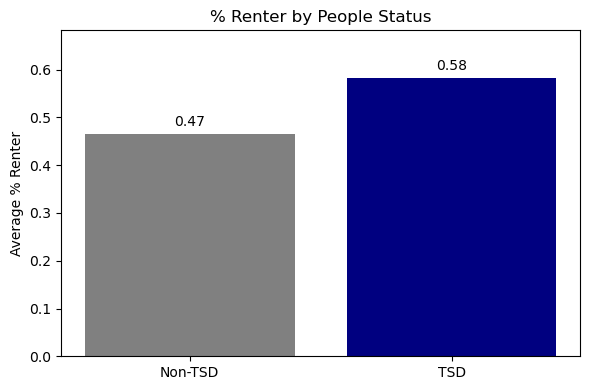

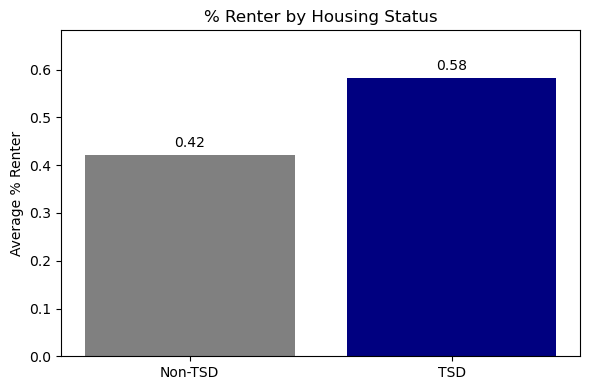

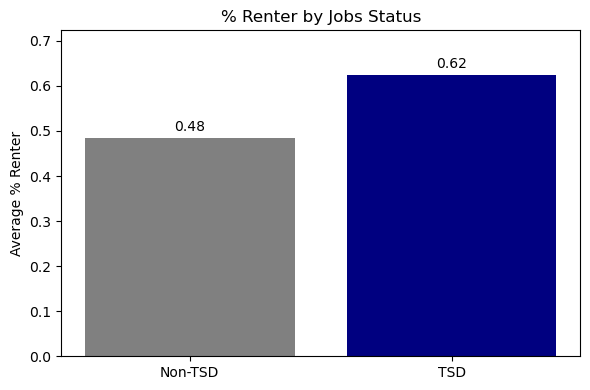

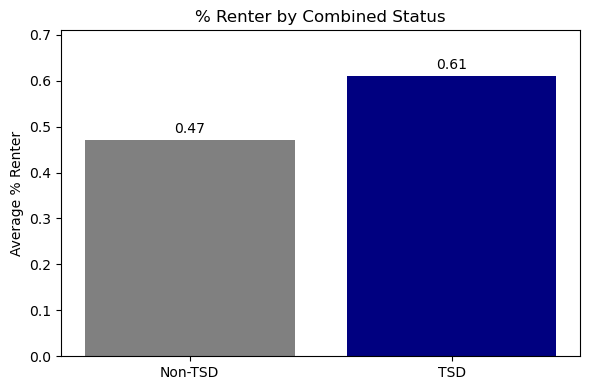

In [36]:
metrics = ["tsd_people", "tsd_housing", "tsd_jobs", "tsd_combined"]

for metric in metrics:
    group_means = station_summary.groupby(metric)["pct_renters"].mean()
    labels = ["Non-TSD", "TSD"]
    values = [group_means.get(False, 0), group_means.get(True, 0)]

    plt.figure(figsize=(6, 4))
    bars = plt.bar(labels, values, color=["gray", "navy"])
    plt.title(f"% Renter by {metric.replace('tsd_', '').title()} Status")
    plt.ylabel("Average % Renter")
    plt.ylim(0, max(values) + 0.1)

    # Add value labels
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig("renterbymetric.png", dpi=300, bbox_inches="tight")
    plt.show()

In [22]:
from scipy.stats import mannwhitneyu

for metric in metrics:
    group_true = station_summary[station_summary[metric]]["pct_black"].dropna()
    group_false = station_summary[~station_summary[metric]]["pct_black"].dropna()

    stat, p = mannwhitneyu(group_true, group_false, alternative='two-sided')
    print(f"{metric} → Mann-Whitney U p-value: {p:.4f}")

tsd_people → Mann-Whitney U p-value: 0.5856
tsd_housing → Mann-Whitney U p-value: 0.2630
tsd_jobs → Mann-Whitney U p-value: 0.0148
tsd_combined → Mann-Whitney U p-value: 0.0068


In [33]:
from scipy.stats import mannwhitneyu

for metric in metrics:
    group_true = station_summary[station_summary[metric]]["pct_poverty"].dropna()
    group_false = station_summary[~station_summary[metric]]["pct_poverty"].dropna()

    stat, p = mannwhitneyu(group_true, group_false, alternative='two-sided')
    print(f"{metric} → Mann-Whitney U p-value: {p:.4f}")

tsd_people → Mann-Whitney U p-value: 0.9036
tsd_housing → Mann-Whitney U p-value: 1.0000
tsd_jobs → Mann-Whitney U p-value: 0.4165
tsd_combined → Mann-Whitney U p-value: 0.7634


In [35]:
from scipy.stats import mannwhitneyu

for metric in metrics:
    group_true = station_summary[station_summary[metric]]["pct_renters"].dropna()
    group_false = station_summary[~station_summary[metric]]["pct_renters"].dropna()

    stat, p = mannwhitneyu(group_true, group_false, alternative='two-sided')
    print(f"{metric} → Mann-Whitney U p-value: {p:.4f}")

tsd_people → Mann-Whitney U p-value: 0.0340
tsd_housing → Mann-Whitney U p-value: 0.0087
tsd_jobs → Mann-Whitney U p-value: 0.0000
tsd_combined → Mann-Whitney U p-value: 0.0001


In [27]:
from statsmodels.stats.contingency_tables import mcnemar
import pandas as pd

# List of TSD flags
metrics = ["tsd_people", "tsd_housing", "tsd_jobs", "tsd_combined"]

# Compare each pair of metrics
print("McNemar’s Test Results (Are metrics significantly different?):\n")

for i in range(len(metrics)):
    for j in range(i+1, len(metrics)):
        m1, m2 = metrics[i], metrics[j]

        # Build 2x2 contingency table
        both = station_summary[[m1, m2]]
        table = pd.crosstab(both[m1], both[m2])

        if table.shape == (2, 2):
            result = mcnemar(table, exact=False, correction=True)
            pval = result.pvalue
            print(f"{m1.replace('tsd_', '')} vs {m2.replace('tsd_', '')}:\tp = {pval:.4f}")
        else:
            print(f"{m1} vs {m2}: Not enough variation for test.")

McNemar’s Test Results (Are metrics significantly different?):

people vs housing:	p = 0.2482
people vs jobs:	p = 0.0244
people vs combined:	p = 0.1489
housing vs jobs:	p = 0.0009
housing vs combined:	p = 0.0077
jobs vs combined:	p = 0.1336


In [29]:
summary_table = pd.DataFrame()

for metric in metrics:
    avg_black = station_summary.groupby(metric)["pct_black"].mean()
    count = station_summary[metric].value_counts().rename(index={True: "TSD", False: "Non-TSD"})
    summary_table[metric.replace("tsd_", "")] = [avg_black.get(False, None), avg_black.get(True, None)]

summary_table.index = ["Non-TSD Avg % Black", "TSD Avg % Black"]
summary_table = summary_table.T.round(3)

# Save to CSV for write-up
summary_table.to_csv("tsd_equity_summary_table.csv")

# Display the table
summary_table

,Non-TSD Avg % Black,TSD Avg % Black
people,0.394,0.294
housing,0.466,0.285
jobs,0.424,0.208
combined,0.469,0.212
